In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.data import crop
from csng.data import get_dataloaders
from csng.utils.mix import seed_all, update_config_paths, plot_comparison
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [2]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min"},
    "crop_wins": dict(),
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


# Data

## Load source dataset(s)

In [3]:
### prep data config
# brainreader mouse data
# config["data"]["brainreader_mouse"] = {
#     "device": config["device"],
#     "mixing_strategy": config["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 8,
#     # "sessions": list(range(1, 23)),
#     "sessions": [6],
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": False,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
# }

### cat v1 data
config["data"]["cat_v1"] = {
    "crop_win": (20, 20),
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 8,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 20.420,
        "resp_normalize_mean": None, # don't center responses
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
        "clamp_neg_resp": False,
        # "training_sample_idxs": np.random.choice(45000, size=22330, replace=False),
    },
}
config["crop_wins"]["cat_v1"] = config["data"]["cat_v1"]["crop_win"]

# # mouse v1 data
# config["data"]["mouse_v1"] = {
#     "dataset_fn": "sensorium.datasets.static_loaders",
#     "dataset_config": {
#         "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
#             os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
#             os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
#             os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
#             os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
#             os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
#         ],
#         "normalize": True,
#         "scale": 0.25, # 256x144 -> 64x36
#         "include_behavior": False,
#         "add_behavior_as_channels": False,
#         "include_eye_position": True,
#         "exclude": None,
#         "file_tree": True,
#         "cuda": "cuda" in config["device"],
#         "batch_size": 8,
#         "seed": config["seed"],
#         "use_cache": False,
#     },
#     "crop_win": (22, 36),
#     "skip_train": False,
#     "skip_val": False,
#     "skip_test": False,
#     "normalize_neuron_coords": True,
#     "average_test_multitrial": True,
#     "save_test_multitrial": True,
#     "test_batch_size": 7,
#     "device": config["device"],
# }
# config["crop_wins"]["mouse_v1"] = config["data"]["mouse_v1"]["crop_win"]

In [4]:
dls, neuron_coords = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  cat_v1: 5625 batches
    data keys: cat_v1
    size of datasets: 45000
val:
  cat_v1: 625 batches
    data keys: cat_v1
    size of datasets: 5000
test:
  cat_v1: 31 batches
    data keys: cat_v1
    size of datasets: 248


Training dataset:	 45000 samples
Validation dataset:	 5000 samples
Test dataset:		 248 samples

stimuli:
  torch.Size([8, 1, 50, 50])
  min=-2.207  max=2.618
  mean=0.126  std=1.288
responses:
  torch.Size([8, 46875])
  min=0.000  max=15.005
  mean=0.949  std=0.756


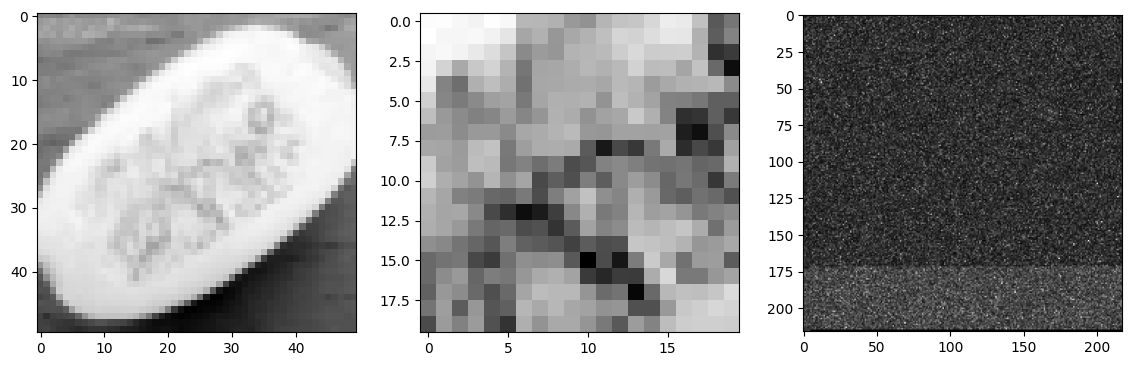

In [5]:
### show data
sample_dataset = "cat_v1"
sample_data_key = "cat_v1"
tier = "test"
sample_idx = 0

datapoint = next(iter(dls[tier][sample_dataset].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][sample_dataset].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][sample_dataset].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][sample_dataset].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

## Load other external data

In [6]:
### shapes:
# responses: (batch, n_neurons)
# neural coordinates: {dataset_name: {data_key: (n_neurons, 2)}}

---
# Decoding models

## Generative Adversarial Network (GAN)

In [7]:
### config for model to load
config["decoder"] = {
    "load_ckpt": {
        "load_only_core": False,
        "load_best": False,
        "load_opter_state": True,
        "load_history": True,
        "reset_best": False,
        "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2025-01-10_17-26-27", "ckpt", "decoder_94.pt"),
        "resume_checkpointing": False,
        "resume_wandb_id": None,
    },
}

def merge_configs_fn(cfg, ckpt_cfg):
    load_ckpt_cfg = deepcopy(cfg["decoder"]["load_ckpt"])
    cfg = ckpt_cfg = update_config_paths(config=ckpt_cfg, new_data_path=DATA_PATH)
    cfg["decoder"]["load_ckpt"] = load_ckpt_cfg
    return cfg, ckpt_cfg

In [8]:
### load model
cfg, gan, loss_fn, history, best, ckpt = init_gan_decoder(config=config, merge_configs_fn=merge_configs_fn)
_ = gan.eval()

[INFO] Loading checkpoint from /media/jan/ext_ssd/csng_data/models/gan/2025-01-10_17-26-27/ckpt/decoder_94.pt...


In [9]:
### decode
with torch.no_grad():
    stim_pred = gan(
        resp.to(config["device"]),
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_dataset][sample_data_key]
    ) # (batch, n_channels, h, w)

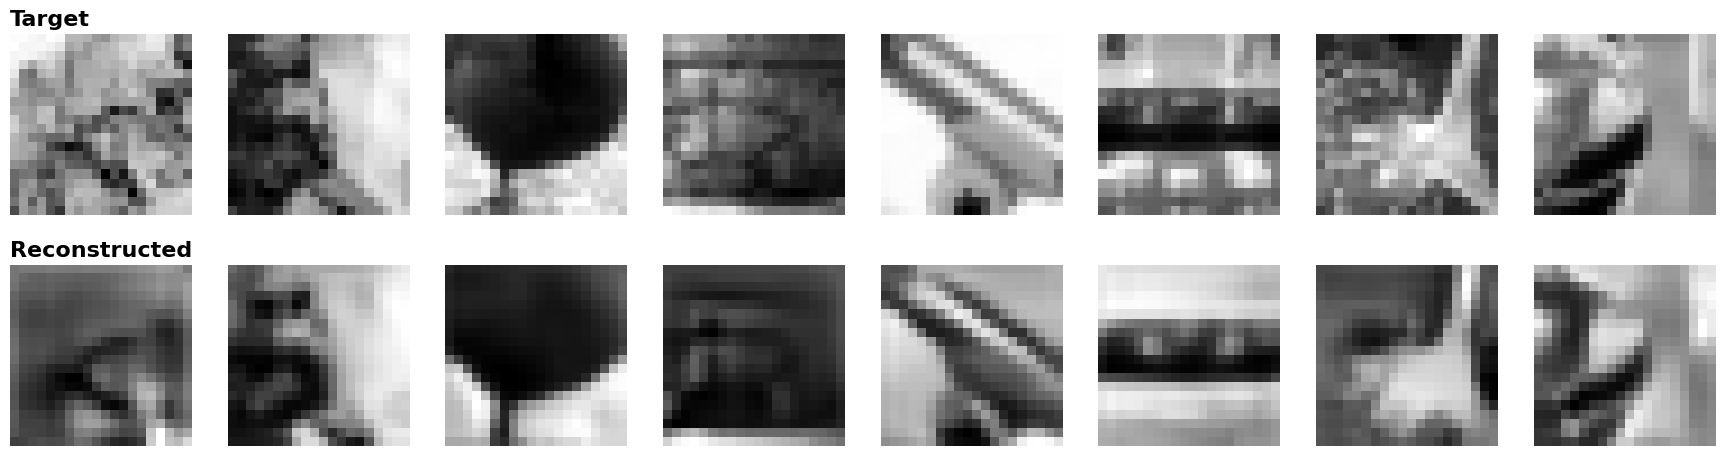

In [10]:
### show comparison
fig = plot_comparison(
    target=crop(stim[:8], config["crop_wins"][sample_data_key]).cpu(),
    pred=crop(stim_pred[:8], config["crop_wins"][sample_data_key]).cpu(),
    show=True,
)